# Kaggle Loan Prediction Competition

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

### Data Analysis

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

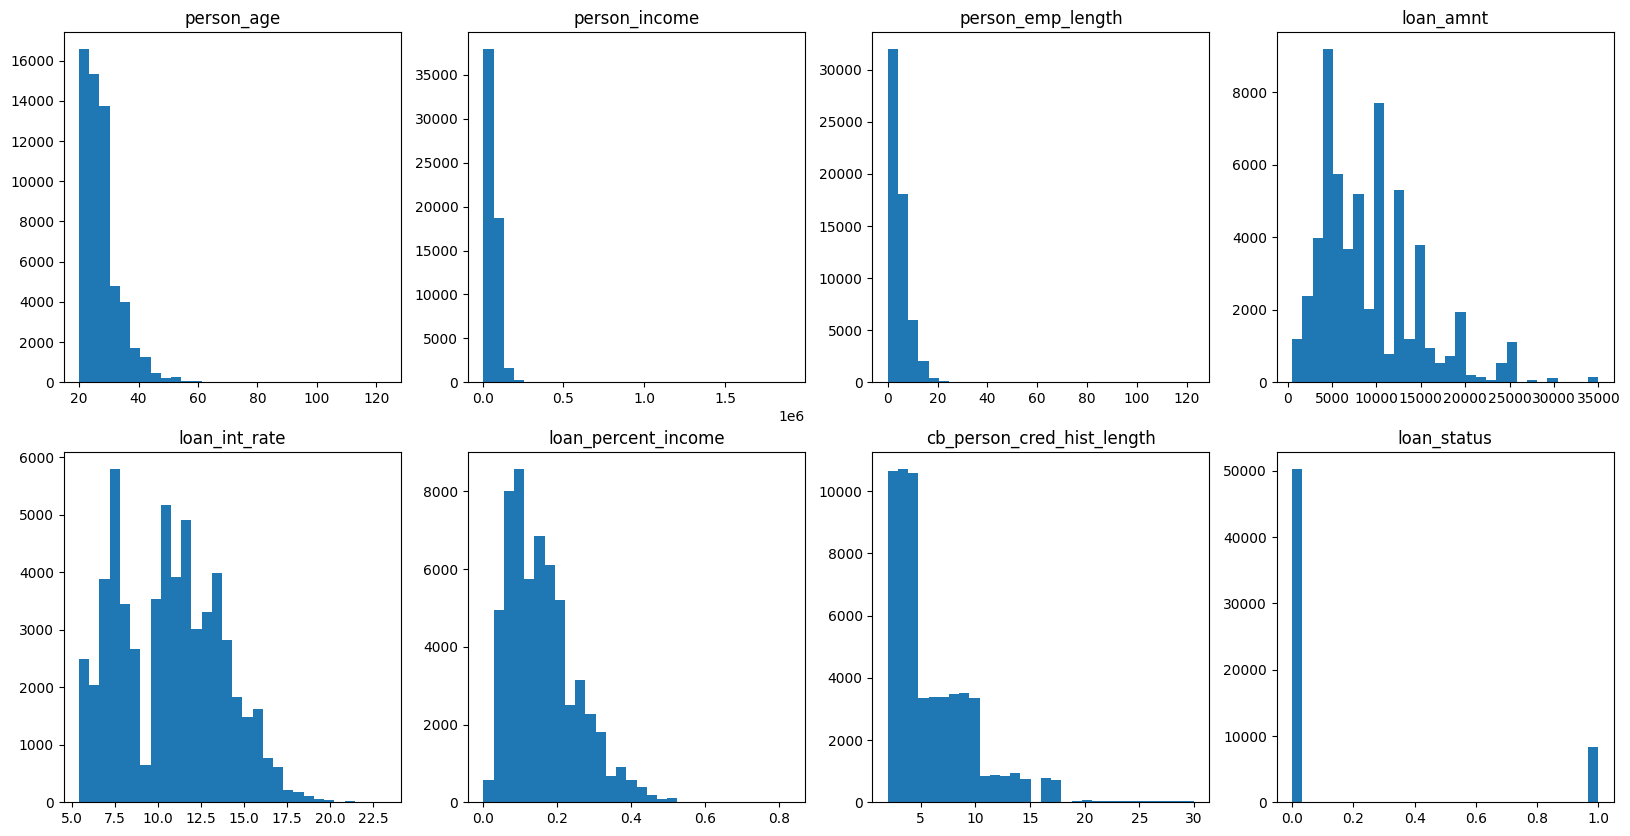

In [3]:
ax, fig = plt.subplots(2,4, figsize=(20,10))
idx = 0
for col in train_data.columns:
    if col == 'id' or train_data[col].dtype == 'object':
            continue
    else:
        x = idx // 4
        y = idx % 4
        fig[x,y].hist(train_data[col], bins=30)
        fig[x,y].set_title(col)
        idx += 1
plt.show()

### Feature Engineering

In [4]:
class SelectTextFeatures(BaseEstimator):
    def fit(self, X : pd.DataFrame, y = None) -> pd.DataFrame:
        return X.loc[:, X.dtypes == 'object']

class SelectNumericalFeatures(BaseEstimator):
    def fit(self, X : pd.DataFrame, y = None) -> pd.DataFrame:
        return X.loc[:, (X.dtypes != 'object') & (X.columns != 'id')]

In [5]:
# Initialize OneHotEncoder and select text features
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform text features in one step
train_text_features = pd.DataFrame(
    encoder.fit_transform(SelectTextFeatures().fit(train_data)), 
    columns=encoder.get_feature_names_out()
)
test_text_features = pd.DataFrame(
    encoder.fit_transform(SelectTextFeatures().fit(test_data)), 
    columns=encoder.get_feature_names_out()
)

# Select numerical features
train_numerical_features = SelectNumericalFeatures().fit(train_data)
test_numerical_features = SelectNumericalFeatures().fit(test_data)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_x = pd.concat([train_numerical_features, train_text_features], axis=1)
train_x, val_x = train_test_split(train_x, test_size=0.2)
train_y = train_x["loan_status"]
val_y = val_x["loan_status"]
train_x = train_x.drop(columns=["loan_status"])
val_x = val_x.drop(columns=["loan_status"])

test_x = pd.concat([test_numerical_features, test_text_features], axis=1)

scaler = scaler.fit(train_x)

scaled_train_x = scaler.transform(train_x)
scaled_test_x = scaler.transform(test_x)
scaled_val_x = scaler.transform(val_x)

### Model Creation

In [7]:
def plot_roc_curve(y,y_hat):
    fpr, tpr, _ = roc_curve(y, y_hat)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

In [8]:
def fit_model(model_, param_grid: dict, train_x: pd.DataFrame, train_y: pd.DataFrame, val_x: pd.DataFrame):
    grid_search = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='roc_auc', cv=10, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    return grid_search.best_estimator_

XGBoost

In [288]:
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [500, 1_000],      # Number of boosting rounds
    'max_depth': [3, 5],               # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.15],    # Step size shrinkage
    'subsample': [0.8, 1.0],              # Fraction of samples to be used for each tree
    'colsample_bytree': [0.8, 1.0]        # Fraction of features to be used for each tree
}
xgb_model = XGBClassifier(random_state=42)

best_xgb = fit_model(xgb_model, param_grid, scaled_train_x, train_y, scaled_val_x)

/home/work/cole/Projects/Loan_Prediction/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


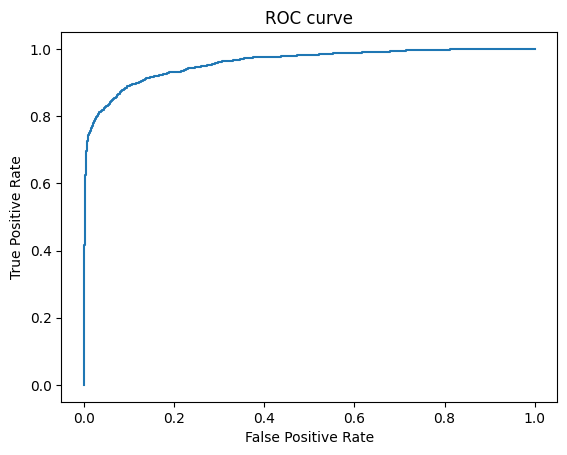

0.9588913321895465


In [290]:
y_hat = best_xgb.predict_proba(scaled_val_x)[:,1]
plot_roc_curve(val_y, y_hat)
print(roc_auc_score(val_y, y_hat))

CatBoost

In [14]:
from catboost import CatBoostClassifier

cat_param_grid = {
    'iterations': [100, 200, 500],      # Number of boosting rounds
    'depth': [3, 5, 7]              # Maximum depth of a tree
}

cat_model = CatBoostClassifier(random_state=42,verbose=0)

best_cat = fit_model(cat_model, cat_param_grid, scaled_train_x, train_y, scaled_val_x)

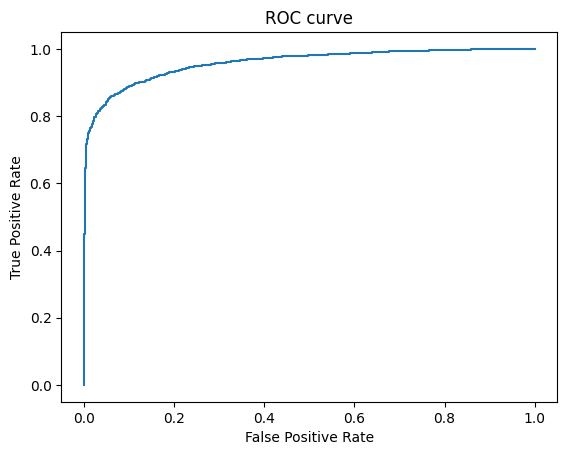

0.9583017756313557



KeyboardInterrupt



In [295]:
y_hat = best_cat.predict_proba(scaled_val_x)[:,1]
plot_roc_curve(val_y, y_hat)
print(roc_auc_score(val_y, y_hat))

LightGBM

In [12]:
from lightgbm import LGBMClassifier

lgbm_param_grid = {
    'num_leaves': [20]      # Number of leaves
}

lgbm_model = LGBMClassifier(random_state=42,verbose=0)

best_lgbm = fit_model(lgbm_model, lgbm_param_grid, scaled_train_x, train_y, scaled_val_x)

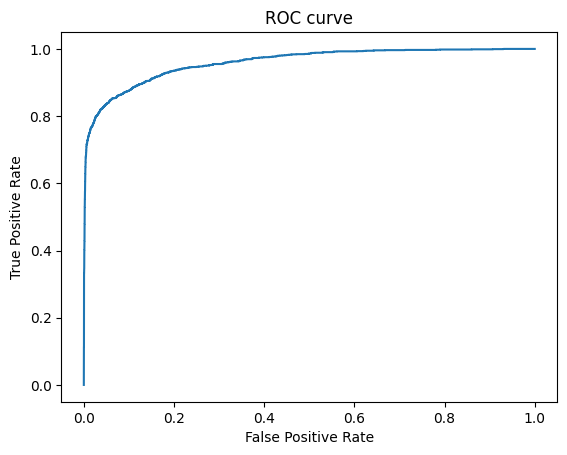

0.9594483428964857


In [13]:
y_hat = best_lgbm.predict_proba(scaled_val_x)[:,1]
plot_roc_curve(val_y, y_hat)
print(roc_auc_score(val_y, y_hat))